# Dataset Description

The NWPU VHR-10 dataset comprises 800 VHR optical remote sensing images, including 715 color images sourced from Google Earth (spatial resolution: 0.5 to 2 m) and 85 pansharpened color infrared images from Vaihingen data (spatial resolution: 0.08 m).

The dataset is split into two sets:
1. Positive image set: 650 images containing at least one target.
2. Negative image set: 150 images devoid of any targets.

Annotations are available for the positive image set, encompassing the following classes:
- Airplanes: 757 instances
- Ships: 302 instances
- Storage tanks: 655 instances
- Baseball diamonds: 390 instances
- Tennis courts: 524 instances
- Basketball courts: 159 instances
- Ground track fields: 163 instances
- Harbors: 224 instances
- Bridges: 124 instances
- Vehicles: 477 instances.

Annotations include bounding boxes and instance masks for precise object delineation.

# Dataset Importing

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
%cd /content/drive/MyDrive/NWPU VHR-10

/content/drive/MyDrive/NWPU VHR-10


# Install and import dectron2

In [11]:
# Install detectron 2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-yprfg9cw
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-yprfg9cw
  Resolved https://github.com/facebookresearch/detectron2.git to commit 5c380fdfc62b0124204155d6be3b1016e3dadb2d
  Preparing metadata (setup.py) ... done


In [12]:
!pip install gdown
!pip install rarfile
!pip install albumentations

In [13]:
# Importing Essential libraries
import os
import matplotlib.pyplot as plt
#Importing CocoTools to load, manipulate, convert and visualize COCO format datasets
from pycocotools.coco import COCO
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer, HookBase
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
from detectron2.utils.logger import setup_logger
from detectron2.data.datasets import register_coco_instances
from detectron2.data import transforms as T
import random
import skimage.io as io
# Set base params
plt.rcParams["figure.figsize"] = [16,9]

# Define Annotation and classes

In [14]:
#Pointing cocotools to the location of the Json that describes the train dataset
#All dataset Json ??
coco = COCO('/content/drive/MyDrive/NWPU VHR-10/train/train.json')

loading annotations into memory...
Done (t=0.37s)
creating index...
index created!


In [15]:
#Load categorries described in Json Files
cats=coco.loadCats(coco.getCatIds())
cats

[{'supercategory': 'airplane', 'id': 1, 'name': 'airplane'},
 {'supercategory': 'ship', 'id': 2, 'name': 'ship'},
 {'supercategory': 'storage tank', 'id': 3, 'name': 'storage tank'},
 {'supercategory': 'baseball diamond', 'id': 4, 'name': 'baseball diamond'},
 {'supercategory': 'tennis court', 'id': 5, 'name': 'tennis court'},
 {'supercategory': 'basketball court', 'id': 6, 'name': 'basketball court'},
 {'supercategory': 'ground track field',
  'id': 7,
  'name': 'ground track field'},
 {'supercategory': 'harbor', 'id': 8, 'name': 'harbor'},
 {'supercategory': 'bridge', 'id': 9, 'name': 'bridge'},
 {'supercategory': 'vehicle', 'id': 10, 'name': 'vehicle'}]

In [16]:
#Extracting names from categories
names=[cat['name'] for cat in cats]
names

['airplane',
 'ship',
 'storage tank',
 'baseball diamond',
 'tennis court',
 'basketball court',
 'ground track field',
 'harbor',
 'bridge',
 'vehicle']

In [17]:
catIds=coco.getCatIds(catNms=['tennis_court','basketball_court'])
# This gets the images where both or all of these categories are present in the image
imgIds = coco.getImgIds(catIds=catIds)

In [18]:
# Create a dictionary between category_id and category name
category_map = dict()

for ele in list(coco.cats.values()):
    category_map.update({ele['id']:ele['name']})
category_map

{1: 'airplane',
 2: 'ship',
 3: 'storage tank',
 4: 'baseball diamond',
 5: 'tennis court',
 6: 'basketball court',
 7: 'ground track field',
 8: 'harbor',
 9: 'bridge',
 10: 'vehicle'}

# Define training and testing directory

In [19]:
train_img_dir = '/content/drive/MyDrive/NWPU VHR-10/train'
test_img_dir = '/content/drive/MyDrive/NWPU VHR-10/test'

# Visualize boxing over a random image


Image details 
 {'id': 385, 'file_name': '100.jpg', 'width': 1078, 'height': 702}
Objects are: ['baseball diamond']


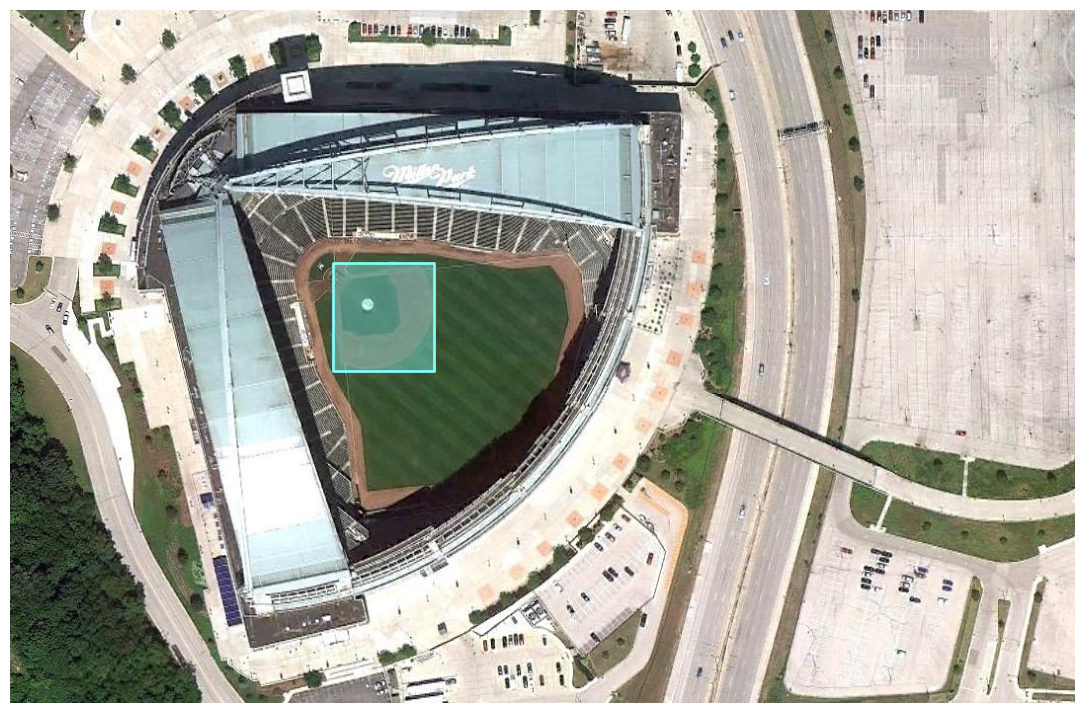

In [20]:
random_img_id=random.choice(imgIds) # Takes a random id
random_img_id
# Load the image
imgId = coco.getImgIds(imgIds = [random_img_id])
img = coco.loadImgs(imgId)[0]
print("Image details \n",img)
#get annotations (description of images' segmentation masks and bounding boxes of each object instance per images)
annIds = coco.getAnnIds(imgIds=imgId,iscrowd=None)
anns = coco.loadAnns(annIds)
#Create a list of objects in the image
parts = []
for region in anns:
    parts.append(category_map[region['category_id']])

print("Objects are:", parts)

#Plot Parts masks
I = io.imread(train_img_dir + '/' + img['file_name'])
plt.imshow(I)
plt.axis('off')
coco.showAnns(anns)

# Setup environment

In [21]:
# To find out inconsistent CUDA versions, if there is not "failed" word in this output then things are fine.
!python -m detectron2.utils.collect_env

-------------------------------  -----------------------------------------------------------------
sys.platform                     linux
Python                           3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
numpy                            1.25.2
detectron2                       0.6 @/usr/local/lib/python3.10/dist-packages/detectron2
Compiler                         GCC 11.4
CUDA compiler                    CUDA 12.2
detectron2 arch flags            7.5
DETECTRON2_ENV_MODULE            <not set>
PyTorch                          2.2.1+cu121 @/usr/local/lib/python3.10/dist-packages/torch
PyTorch debug build              False
torch._C._GLIBCXX_USE_CXX11_ABI  False
GPU available                    Yes
GPU 0                            Tesla T4 (arch=7.5)
Driver version                   535.104.05
CUDA_HOME                        /usr/local/cuda
Pillow                           9.4.0
torchvision                      0.17.1+cu121 @/usr/local/lib/python3.10/dist-packages/torch

In [22]:
!pip install echo1-coco-split

In [23]:
dataset_dir = "/content/drive/MyDrive/NWPU VHR-10"

# Define Tensor dictionaries 

In [24]:
register_coco_instances("train", {}, os.path.join(dataset_dir,"train", "train.json"), train_img_dir)
register_coco_instances("test", {}, os.path.join(dataset_dir,"test", "test.json"), test_img_dir)

In [25]:
dataset_dicts = DatasetCatalog.get("train")
metadata_dicts = MetadataCatalog.get("train")

In [26]:
metadata_dicts

namespace(name='train',
          json_file='/content/drive/MyDrive/NWPU VHR-10/train/train.json',
          image_root='/content/drive/MyDrive/NWPU VHR-10/train',
          evaluator_type='coco',
          thing_classes=['airplane',
                         'ship',
                         'storage tank',
                         'baseball diamond',
                         'tennis court',
                         'basketball court',
                         'ground track field',
                         'harbor',
                         'bridge',
                         'vehicle'],
          thing_dataset_id_to_contiguous_id={1: 0,
                                             2: 1,
                                             3: 2,
                                             4: 3,
                                             5: 4,
                                             6: 5,
                                             7: 6,
                                             8: 7,

# Data Augmentation


In [27]:
# Import necessary modules
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
import copy
import torch

# Define a custom mapper function that will be used to process each data sample
def custom_mapper(dataset_dict):
    # Make a deep copy of the dataset dictionary to avoid modifying the original data
    dataset_dict = copy.deepcopy(dataset_dict)
    
    # Read the image from the file using OpenCV's utility function and convert it to BGR format
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Define a list of image transformations to be applied
    transform_list = [
        T.Resize((1024,1024)),  # Resize the image to a fixed size of 1024x1024 pixels
        T.RandomBrightness(0.9, 1.2),  # Randomly adjust brightness within the specified range
        T.RandomContrast(0.9, 1.2),  # Randomly adjust contrast within the specified range
        T.RandomSaturation(0.9, 1.2),  # Randomly adjust saturation within the specified range
#         T.RandomRotation(angle=[90, 90]),  # (Optional) Randomly rotate the image within the specified angle range
        T.RandomLighting(0.7),  # Randomly apply lighting changes with the specified probability
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),  # Randomly flip the image horizontally with the specified probability
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),  # Randomly flip the image vertically with the specified probability
    ]
    
    # Apply the defined transformations to the image
    image, transforms = T.apply_transform_gens(transform_list, image)
    
    # Convert the transformed image to a PyTorch tensor and rearrange dimensions to (C, H, W)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    # Transform annotations for each object instance in the image
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")  # Remove annotations from the dataset dictionary
        if obj.get("iscrowd", 0) == 0  # Filter out instances that are crowd objects
    ]
    
    # Convert transformed annotations to instance objects
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    
    # Filter out empty instances (instances with no objects)
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    
    # Return the modified dataset dictionary
    return dataset_dict


# Definition of the Model

In [28]:
# Import necessary modules
from detectron2.config import get_cfg
import detectron2.model_zoo as model_zoo

# Create a config object
cfg = get_cfg()

# Load a pre-defined model configuration and its weights from the model zoo
base_model = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg.merge_from_file(model_zoo.get_config_file(base_model))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model)

# Define training and testing datasets
cfg.DATASETS.TRAIN = ("train",)  # Training dataset name
cfg.DATASETS.TEST = ("test",)  # Testing dataset name

# Configure data loader settings
cfg.DATALOADER.NUM_WORKERS = 2  # Number of data loading workers
cfg.SOLVER.IMS_PER_BATCH = 2  # Number of images per batch

# Configure solver settings
cfg.SOLVER.BASE_LR = 0.001  # Base learning rate
cfg.SOLVER.GAMMA = 0.05  # Learning rate decay factor
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Batch size per image for ROI heads

cfg.SOLVER.WARMUP_ITERS = 50  # Number of warm-up iterations
cfg.SOLVER.MAX_ITER = 1000  # Maximum number of training iterations (epochs)
cfg.TEST.EVAL_PERIOD = 100  # Evaluation period during training

# Set the number of classes for the model
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 10  # Number of classes for ROI heads
cfg.MODEL.RETINANET.NUM_CLASSES = 10  # Number of classes for RetinaNet

# Configure optimizer to RMSprop
cfg.SOLVER.OPTIMIZER = "RMSprop"  # Optimizer algorithm
cfg.SOLVER.MOMENTUM = 0.9  # Momentum value
cfg.SOLVER.WEIGHT_DECAY = 0.0005  # Weight decay value

# Set the output directory for saving training results
cfg.OUTPUT_DIR = 'train_output'


# Training

In [29]:
# Import necessary modules
from detectron2.data import build_detection_test_loader, build_detection_train_loader
import os
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

# Define a custom trainer class inheriting from DefaultTrainer
class MyTrainer(DefaultTrainer):
    
    # Define a method to build an evaluator for validation/testing
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        # If no output folder is provided, create one
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        # Return a COCOEvaluator configured with the dataset name, configuration, and output folder
        return COCOEvaluator(dataset_name, cfg, True, output_folder)
        # CocoEvaluator extracts CocoMetrics based on the predictions of the model
    
    # Define a method to build the data loader for training
    @classmethod
    def build_train_loader(cls, cfg):
        # Return a data loader for training with a custom mapper function
        return build_detection_train_loader(cfg, mapper=custom_mapper)
        # custom_mapper is a function for custom data augmentation and preprocessing


In [30]:
# Create an instance of MyTrainer with the provided configuration
trainer = MyTrainer(cfg)

# Resume training from the latest checkpoint if available, or load weights from scratch if resume=False
trainer.resume_or_load(resume=False)

# Start the training process
trainer.train()

[05/05 14:02:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:00, 181MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[05/05 14:02:37 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/05 14:02:55 d2.utils.events]:  eta: 0:12:19  iter: 19  total_loss: 3.008  loss_cls: 1.857  loss_box_reg: 0.4099  loss_mask: 0.6861  loss_rpn_cls: 0.06674  loss_rpn_loc: 0.01584    time: 0.6967  last_time: 0.7483  data_time: 0.1997  last_data_time: 0.2120   lr: 0.00038062  max_mem: 2612M
[05/05 14:03:20 d2.utils.events]:  eta: 0:12:34  iter: 39  total_loss: 2.042  loss_cls: 0.7318  loss_box_reg: 0.5672  loss_mask: 0.591  loss_rpn_cls: 0.06379  loss_rpn_loc: 0.0272    time: 0.7637  last_time: 0.7054  data_time: 0.2022  last_data_time: 0.1862   lr: 0.00078022  max_mem: 2612M
[05/05 14:03:33 d2.utils.events]:  eta: 0:10:36  iter: 59  total_loss: 1.986  loss_cls: 0.7463  loss_box_reg: 0.7569  loss_mask: 0.441  loss_rpn_cls: 0.03251  loss_rpn_loc: 0.02634    time: 0.7208  last_time: 0.6058  data_time: 0.1205  last_data_time: 0.1083   lr: 0.001  max_mem: 2613M
[05/05 14:03:46 d2.utils.events]:  eta: 0:10:00  iter: 79  total_loss: 1.629  loss_cls: 0.566  loss_box_reg: 0.7032  loss_mask: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:04:03 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0016 s/iter. Inference: 0.1309 s/iter. Eval: 0.0950 s/iter. Total: 0.2275 s/iter. ETA=0:00:41
[05/05 14:04:08 d2.evaluation.evaluator]: Inference done 33/195. Dataloading: 0.0019 s/iter. Inference: 0.1305 s/iter. Eval: 0.1035 s/iter. Total: 0.2360 s/iter. ETA=0:00:38
[05/05 14:04:13 d2.evaluation.evaluator]: Inference done 51/195. Dataloading: 0.0057 s/iter. Inference: 0.1332 s/iter. Eval: 0.1152 s/iter. Total: 0.2543 s/iter. ETA=0:00:36
[05/05 14:04:18 d2.evaluation.evaluator]: Inference done 68/195. Dataloading: 0.0048 s/iter. Inference: 0.1348 s/iter. Eval: 0.1273 s/iter. Total: 0.2670 s/iter. ETA=0:00:33
[05/05 14:04:23 d2.evaluation.evaluator]: Inference done 86/195. Dataloading: 0.0045 s/iter. Inference: 0.1351 s/iter. Eval: 0.1299 s/iter. Total: 0.2696 s/iter. ETA=0:00:29
[05/05 14:04:29 d2.evaluation.evaluator]: Inference done 91/195. Dataloading: 0.0471 s/iter. Inference: 0.1360 s/iter. Eval: 0.135

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:04:57 d2.evaluation.evaluator]: Total inference time: 0:00:55.834746 (0.293867 s / iter per device, on 1 devices)
[05/05 14:04:57 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:25 (0.136383 s / iter per device, on 1 devices)
[05/05 14:04:57 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:04:57 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:04:58 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/05 14:04:58 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:04:58 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.14 seconds.
[05/05 14:04:58 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:04:58 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.04 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:06:07 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0016 s/iter. Inference: 0.1165 s/iter. Eval: 0.0195 s/iter. Total: 0.1376 s/iter. ETA=0:00:25
[05/05 14:06:12 d2.evaluation.evaluator]: Inference done 48/195. Dataloading: 0.0019 s/iter. Inference: 0.1149 s/iter. Eval: 0.0221 s/iter. Total: 0.1390 s/iter. ETA=0:00:20
[05/05 14:06:17 d2.evaluation.evaluator]: Inference done 73/195. Dataloading: 0.0023 s/iter. Inference: 0.1214 s/iter. Eval: 0.0392 s/iter. Total: 0.1631 s/iter. ETA=0:00:19
[05/05 14:06:22 d2.evaluation.evaluator]: Inference done 109/195. Dataloading: 0.0023 s/iter. Inference: 0.1187 s/iter. Eval: 0.0340 s/iter. Total: 0.1551 s/iter. ETA=0:00:13
[05/05 14:06:27 d2.evaluation.evaluator]: Inference done 143/195. Dataloading: 0.0023 s/iter. Inference: 0.1185 s/iter. Eval: 0.0325 s/iter. Total: 0.1535 s/iter. ETA=0:00:07
[05/05 14:06:32 d2.evaluation.evaluator]: Inference done 177/195. Dataloading: 0.0028 s/iter. Inference: 0.1180 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:06:35 d2.evaluation.evaluator]: Total inference time: 0:00:28.901793 (0.152115 s / iter per device, on 1 devices)
[05/05 14:06:35 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:22 (0.117742 s / iter per device, on 1 devices)
[05/05 14:06:35 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:06:35 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:06:35 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/05 14:06:35 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:06:35 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.07 seconds.
[05/05 14:06:35 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:06:35 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:07:40 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0018 s/iter. Inference: 0.1172 s/iter. Eval: 0.0172 s/iter. Total: 0.1363 s/iter. ETA=0:00:25
[05/05 14:07:45 d2.evaluation.evaluator]: Inference done 48/195. Dataloading: 0.0020 s/iter. Inference: 0.1169 s/iter. Eval: 0.0172 s/iter. Total: 0.1363 s/iter. ETA=0:00:20
[05/05 14:07:50 d2.evaluation.evaluator]: Inference done 78/195. Dataloading: 0.0026 s/iter. Inference: 0.1186 s/iter. Eval: 0.0291 s/iter. Total: 0.1504 s/iter. ETA=0:00:17
[05/05 14:07:55 d2.evaluation.evaluator]: Inference done 112/195. Dataloading: 0.0026 s/iter. Inference: 0.1190 s/iter. Eval: 0.0284 s/iter. Total: 0.1501 s/iter. ETA=0:00:12
[05/05 14:08:01 d2.evaluation.evaluator]: Inference done 147/195. Dataloading: 0.0025 s/iter. Inference: 0.1192 s/iter. Eval: 0.0274 s/iter. Total: 0.1492 s/iter. ETA=0:00:07
[05/05 14:08:06 d2.evaluation.evaluator]: Inference done 181/195. Dataloading: 0.0027 s/iter. Inference: 0.1219 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:08:08 d2.evaluation.evaluator]: Total inference time: 0:00:28.652574 (0.150803 s / iter per device, on 1 devices)
[05/05 14:08:08 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:23 (0.121459 s / iter per device, on 1 devices)
[05/05 14:08:08 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:08:08 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:08:08 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/05 14:08:08 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:08:08 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[05/05 14:08:08 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:08:08 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:09:15 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0054 s/iter. Inference: 0.1223 s/iter. Eval: 0.0271 s/iter. Total: 0.1549 s/iter. ETA=0:00:28
[05/05 14:09:20 d2.evaluation.evaluator]: Inference done 47/195. Dataloading: 0.0031 s/iter. Inference: 0.1178 s/iter. Eval: 0.0210 s/iter. Total: 0.1420 s/iter. ETA=0:00:21
[05/05 14:09:25 d2.evaluation.evaluator]: Inference done 79/195. Dataloading: 0.0026 s/iter. Inference: 0.1189 s/iter. Eval: 0.0274 s/iter. Total: 0.1491 s/iter. ETA=0:00:17
[05/05 14:09:30 d2.evaluation.evaluator]: Inference done 112/195. Dataloading: 0.0031 s/iter. Inference: 0.1192 s/iter. Eval: 0.0277 s/iter. Total: 0.1502 s/iter. ETA=0:00:12
[05/05 14:09:35 d2.evaluation.evaluator]: Inference done 148/195. Dataloading: 0.0029 s/iter. Inference: 0.1192 s/iter. Eval: 0.0257 s/iter. Total: 0.1479 s/iter. ETA=0:00:06
[05/05 14:09:40 d2.evaluation.evaluator]: Inference done 184/195. Dataloading: 0.0027 s/iter. Inference: 0.1185 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:09:42 d2.evaluation.evaluator]: Total inference time: 0:00:28.023218 (0.147491 s / iter per device, on 1 devices)
[05/05 14:09:42 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:22 (0.118768 s / iter per device, on 1 devices)
[05/05 14:09:42 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:09:42 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:09:42 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[05/05 14:09:42 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:09:42 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.12 seconds.
[05/05 14:09:42 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:09:42 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.05 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:10:47 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0020 s/iter. Inference: 0.1175 s/iter. Eval: 0.0128 s/iter. Total: 0.1323 s/iter. ETA=0:00:24
[05/05 14:10:52 d2.evaluation.evaluator]: Inference done 47/195. Dataloading: 0.0023 s/iter. Inference: 0.1198 s/iter. Eval: 0.0179 s/iter. Total: 0.1402 s/iter. ETA=0:00:20
[05/05 14:10:57 d2.evaluation.evaluator]: Inference done 79/195. Dataloading: 0.0025 s/iter. Inference: 0.1202 s/iter. Eval: 0.0257 s/iter. Total: 0.1486 s/iter. ETA=0:00:17
[05/05 14:11:03 d2.evaluation.evaluator]: Inference done 117/195. Dataloading: 0.0024 s/iter. Inference: 0.1183 s/iter. Eval: 0.0229 s/iter. Total: 0.1438 s/iter. ETA=0:00:11
[05/05 14:11:08 d2.evaluation.evaluator]: Inference done 151/195. Dataloading: 0.0026 s/iter. Inference: 0.1193 s/iter. Eval: 0.0233 s/iter. Total: 0.1454 s/iter. ETA=0:00:06
[05/05 14:11:13 d2.evaluation.evaluator]: Inference done 189/195. Dataloading: 0.0026 s/iter. Inference: 0.1186 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:12:20 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0055 s/iter. Inference: 0.1242 s/iter. Eval: 0.0198 s/iter. Total: 0.1496 s/iter. ETA=0:00:27
[05/05 14:12:25 d2.evaluation.evaluator]: Inference done 50/195. Dataloading: 0.0025 s/iter. Inference: 0.1168 s/iter. Eval: 0.0136 s/iter. Total: 0.1330 s/iter. ETA=0:00:19
[05/05 14:12:30 d2.evaluation.evaluator]: Inference done 83/195. Dataloading: 0.0023 s/iter. Inference: 0.1179 s/iter. Eval: 0.0216 s/iter. Total: 0.1419 s/iter. ETA=0:00:15
[05/05 14:12:35 d2.evaluation.evaluator]: Inference done 118/195. Dataloading: 0.0026 s/iter. Inference: 0.1181 s/iter. Eval: 0.0223 s/iter. Total: 0.1431 s/iter. ETA=0:00:11
[05/05 14:12:40 d2.evaluation.evaluator]: Inference done 154/195. Dataloading: 0.0025 s/iter. Inference: 0.1182 s/iter. Eval: 0.0215 s/iter. Total: 0.1423 s/iter. ETA=0:00:05
[05/05 14:12:45 d2.evaluation.evaluator]: Inference done 192/195. Dataloading: 0.0026 s/iter. Inference: 0.1176 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:13:53 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0016 s/iter. Inference: 0.1169 s/iter. Eval: 0.0118 s/iter. Total: 0.1303 s/iter. ETA=0:00:23
[05/05 14:13:58 d2.evaluation.evaluator]: Inference done 47/195. Dataloading: 0.0051 s/iter. Inference: 0.1196 s/iter. Eval: 0.0132 s/iter. Total: 0.1380 s/iter. ETA=0:00:20
[05/05 14:14:03 d2.evaluation.evaluator]: Inference done 82/195. Dataloading: 0.0037 s/iter. Inference: 0.1188 s/iter. Eval: 0.0187 s/iter. Total: 0.1412 s/iter. ETA=0:00:15
[05/05 14:14:08 d2.evaluation.evaluator]: Inference done 120/195. Dataloading: 0.0034 s/iter. Inference: 0.1171 s/iter. Eval: 0.0177 s/iter. Total: 0.1384 s/iter. ETA=0:00:10
[05/05 14:14:13 d2.evaluation.evaluator]: Inference done 154/195. Dataloading: 0.0033 s/iter. Inference: 0.1183 s/iter. Eval: 0.0188 s/iter. Total: 0.1406 s/iter. ETA=0:00:05
[05/05 14:14:18 d2.evaluation.evaluator]: Inference done 194/195. Dataloading: 0.0030 s/iter. Inference: 0.1174 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:14:18 d2.evaluation.evaluator]: Total inference time: 0:00:26.244080 (0.138127 s / iter per device, on 1 devices)
[05/05 14:14:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:22 (0.117355 s / iter per device, on 1 devices)
[05/05 14:14:18 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:14:18 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:14:18 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/05 14:14:18 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:14:18 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.06 seconds.
[05/05 14:14:18 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:14:18 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:15:24 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0016 s/iter. Inference: 0.1165 s/iter. Eval: 0.0100 s/iter. Total: 0.1281 s/iter. ETA=0:00:23
[05/05 14:15:29 d2.evaluation.evaluator]: Inference done 51/195. Dataloading: 0.0019 s/iter. Inference: 0.1146 s/iter. Eval: 0.0101 s/iter. Total: 0.1267 s/iter. ETA=0:00:18
[05/05 14:15:34 d2.evaluation.evaluator]: Inference done 84/195. Dataloading: 0.0026 s/iter. Inference: 0.1177 s/iter. Eval: 0.0172 s/iter. Total: 0.1376 s/iter. ETA=0:00:15
[05/05 14:15:39 d2.evaluation.evaluator]: Inference done 122/195. Dataloading: 0.0026 s/iter. Inference: 0.1170 s/iter. Eval: 0.0172 s/iter. Total: 0.1368 s/iter. ETA=0:00:09
[05/05 14:15:45 d2.evaluation.evaluator]: Inference done 159/195. Dataloading: 0.0025 s/iter. Inference: 0.1173 s/iter. Eval: 0.0171 s/iter. Total: 0.1369 s/iter. ETA=0:00:04
[05/05 14:15:50 d2.evaluation.evaluator]: Total inference time: 0:00:26.078581 (0.137256 s / iter per device, on 1 devices)
[05/

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:16:55 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0016 s/iter. Inference: 0.1178 s/iter. Eval: 0.0104 s/iter. Total: 0.1298 s/iter. ETA=0:00:23
[05/05 14:17:00 d2.evaluation.evaluator]: Inference done 47/195. Dataloading: 0.0036 s/iter. Inference: 0.1208 s/iter. Eval: 0.0132 s/iter. Total: 0.1377 s/iter. ETA=0:00:20
[05/05 14:17:05 d2.evaluation.evaluator]: Inference done 82/195. Dataloading: 0.0030 s/iter. Inference: 0.1196 s/iter. Eval: 0.0186 s/iter. Total: 0.1414 s/iter. ETA=0:00:15
[05/05 14:17:10 d2.evaluation.evaluator]: Inference done 120/195. Dataloading: 0.0028 s/iter. Inference: 0.1180 s/iter. Eval: 0.0179 s/iter. Total: 0.1388 s/iter. ETA=0:00:10
[05/05 14:17:15 d2.evaluation.evaluator]: Inference done 155/195. Dataloading: 0.0028 s/iter. Inference: 0.1189 s/iter. Eval: 0.0185 s/iter. Total: 0.1404 s/iter. ETA=0:00:05
[05/05 14:17:20 d2.evaluation.evaluator]: Inference done 195/195. Dataloading: 0.0026 s/iter. Inference: 0.1179 s/iter. Eval: 0.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:17:20 d2.evaluation.evaluator]: Total inference time: 0:00:26.165486 (0.137713 s / iter per device, on 1 devices)
[05/05 14:17:20 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:22 (0.117886 s / iter per device, on 1 devices)
[05/05 14:17:20 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:17:20 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[05/05 14:17:20 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/05 14:17:20 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:17:20 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[05/05 14:17:20 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:17:20 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:18:27 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0018 s/iter. Inference: 0.1190 s/iter. Eval: 0.0115 s/iter. Total: 0.1323 s/iter. ETA=0:00:24
[05/05 14:18:32 d2.evaluation.evaluator]: Inference done 47/195. Dataloading: 0.0028 s/iter. Inference: 0.1212 s/iter. Eval: 0.0159 s/iter. Total: 0.1400 s/iter. ETA=0:00:20
[05/05 14:18:37 d2.evaluation.evaluator]: Inference done 73/195. Dataloading: 0.0035 s/iter. Inference: 0.1262 s/iter. Eval: 0.0305 s/iter. Total: 0.1604 s/iter. ETA=0:00:19
[05/05 14:18:43 d2.evaluation.evaluator]: Inference done 108/195. Dataloading: 0.0031 s/iter. Inference: 0.1262 s/iter. Eval: 0.0262 s/iter. Total: 0.1556 s/iter. ETA=0:00:13
[05/05 14:18:48 d2.evaluation.evaluator]: Inference done 143/195. Dataloading: 0.0030 s/iter. Inference: 0.1252 s/iter. Eval: 0.0247 s/iter. Total: 0.1530 s/iter. ETA=0:00:07
[05/05 14:18:53 d2.evaluation.evaluator]: Inference done 178/195. Dataloading: 0.0031 s/iter. Inference: 0.1242 s/iter. Eval: 0.

In [31]:
import torch
print(torch.cuda.is_available())

True


# Prediction function

In [33]:
# Set the model weights to a specific path
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/NWPU VHR-10/train_output/model_final.pth"

# Set the score threshold for post-processing the predictions during testing
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Create a predictor using the configuration
predictor = DefaultPredictor(cfg)

# Create a COCOEvaluator for evaluating the model on the test dataset
evaluator = COCOEvaluator("test", cfg, False, output_dir="./output/")

# Build a data loader for testing using the provided configuration and the test dataset
val_loader = build_detection_test_loader(cfg, "test")

# Perform inference on the test dataset and evaluate the model's performance using the evaluator
# Inference is performed by the predictor's model, and results are evaluated using the provided evaluator
# The evaluation results are printed
print(inference_on_dataset(predictor.model, val_loader, evaluator))


[05/05 14:39:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/NWPU VHR-10/train_output/model_final.pth ...
WARNING [05/05 14:39:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[05/05 14:39:45 d2.data.datasets.coco]: Loaded 195 images in COCO format from /content/drive/MyDrive/NWPU VHR-10/test/test.json
[05/05 14:39:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/05 14:39:45 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/05 14:39:45 d2.data.common]: Serializing 195 elements to byte tensors and concatenating them all ...
[05/05 14:39:45 d2.data.common]: Serialized dataset takes 0.12 MiB
[05/05 14:39:45 d2.evaluation.evaluator]: Start inference on 195 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:39:46 d2.evaluation.evaluator]: Inference done 11/195. Dataloading: 0.0063 s/iter. Inference: 0.1140 s/iter. Eval: 0.0074 s/iter. Total: 0.1277 s/iter. ETA=0:00:23
[05/05 14:39:52 d2.evaluation.evaluator]: Inference done 53/195. Dataloading: 0.0030 s/iter. Inference: 0.1107 s/iter. Eval: 0.0083 s/iter. Total: 0.1221 s/iter. ETA=0:00:17
[05/05 14:39:57 d2.evaluation.evaluator]: Inference done 93/195. Dataloading: 0.0026 s/iter. Inference: 0.1093 s/iter. Eval: 0.0117 s/iter. Total: 0.1237 s/iter. ETA=0:00:12
[05/05 14:40:02 d2.evaluation.evaluator]: Inference done 134/195. Dataloading: 0.0028 s/iter. Inference: 0.1098 s/iter. Eval: 0.0111 s/iter. Total: 0.1238 s/iter. ETA=0:00:07
[05/05 14:40:07 d2.evaluation.evaluator]: Inference done 177/195. Dataloading: 0.0028 s/iter. Inference: 0.1089 s/iter. Eval: 0.0102 s/iter. Total: 0.1220 s/iter. ETA=0:00:02


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[05/05 14:40:09 d2.evaluation.evaluator]: Total inference time: 0:00:23.135630 (0.121766 s / iter per device, on 1 devices)
[05/05 14:40:09 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:20 (0.108630 s / iter per device, on 1 devices)
[05/05 14:40:09 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[05/05 14:40:09 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[05/05 14:40:09 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[05/05 14:40:09 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[05/05 14:40:09 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.05 seconds.
[05/05 14:40:09 d2.evaluation.fast_eval_api]: Accumulating evaluation results...
[05/05 14:40:09 d2.evaluation.fast_eval_api]: COCOeval_opt.accumulate() finished in 0.03 seconds.
 Average Precision  (AP)

# Visualization


In [34]:
import os
import random
import numpy as np
from PIL import Image
import albumentations as A
from sklearn.model_selection import train_test_split
import os
import gdown
import zipfile  # Ensure zipfile is imported


In [35]:
# Set the directory path to save the dataset
dataset_path = '/content/drive/MyDrive/datasets/NWPU_VHR-10'

# Create the directory if it doesn't exist
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

# Construct the Google Drive download URL
url = f'https://drive.google.com/uc?export=download&id=1gpA4wXgxuQU-7B45wtOOu_pQvqyKJVyB'

# Path to save the downloaded zip file
file_path = os.path.join(dataset_path, 'NWPU_VHR-10.rar')

# Download the file using gdown
gdown.download(url, file_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=1gpA4wXgxuQU-7B45wtOOu_pQvqyKJVyB
To: /content/drive/MyDrive/datasets/NWPU_VHR-10/NWPU_VHR-10.rar
100%|██████████| 76.8M/76.8M [00:01<00:00, 50.2MB/s]


'/content/drive/MyDrive/datasets/NWPU_VHR-10/NWPU_VHR-10.rar'

In [37]:
import os

# Directory to check
extracted_path = '/content/drive/MyDrive/datasets/NWPU_VHR-10'

# Check if the directory exists
if os.path.exists(extracted_path):
    # List all files in the directory
    files = os.listdir(extracted_path)

    if files:
        print("Files in the directory:")
        for file in files:
            print(file)  # Print each file name
    else:
        print("The directory is empty.")
else:
    print("Directory not found.")


Files in the directory:
NWPU_VHR-10.rar


In [38]:
import rarfile
import os

# Path to the RAR file
rar_path = os.path.join(extracted_path, 'NWPU_VHR-10.rar')

# Check if the RAR file exists
if os.path.isfile(rar_path):
    with rarfile.RarFile(rar_path, 'r') as rar_ref:
        # Extract all files to the same directory
        rar_ref.extractall(extracted_path)
    print("Extraction completed.")
else:
    print("RAR file not found.")

Extraction completed.


In [39]:
import os

# Directory to check
extracted_path = '/content/drive/MyDrive/datasets/NWPU_VHR-10'

# Check if the directory exists
if os.path.exists(extracted_path):
    # List all files in the directory
    files = os.listdir(extracted_path)

    if files:
        print("Files in the directory:")
        for file in files:
            print(file)  # Print each file name
    else:
        print("The directory is empty.")
else:
    print("Directory not found.")


Files in the directory:
NWPU_VHR-10.rar
NWPU VHR-10 dataset


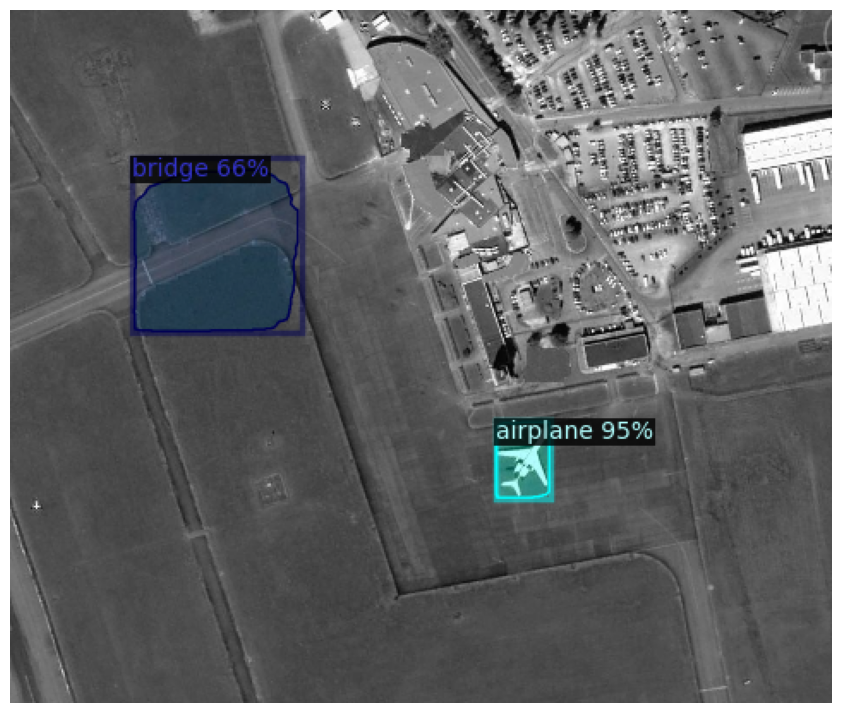

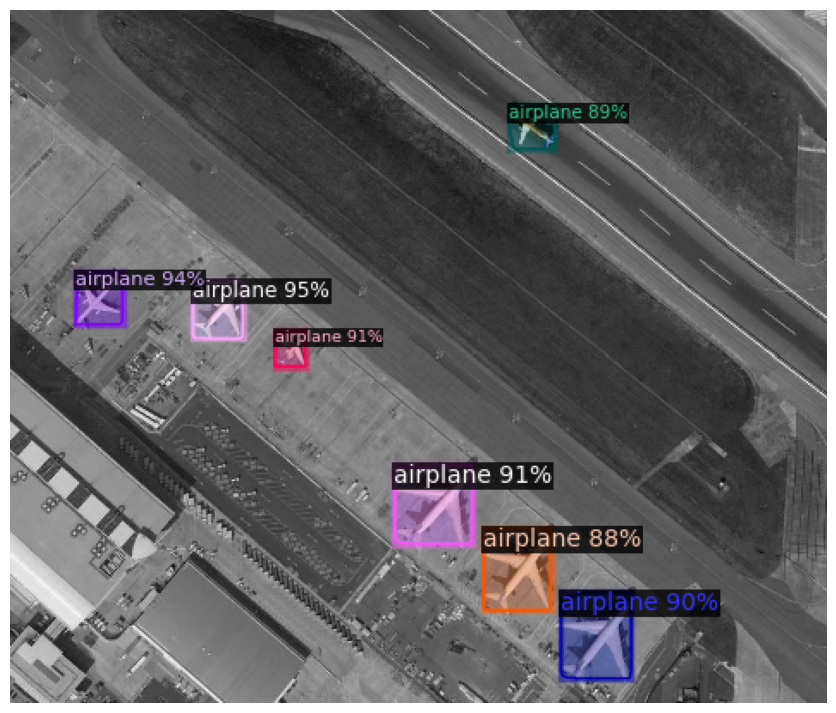

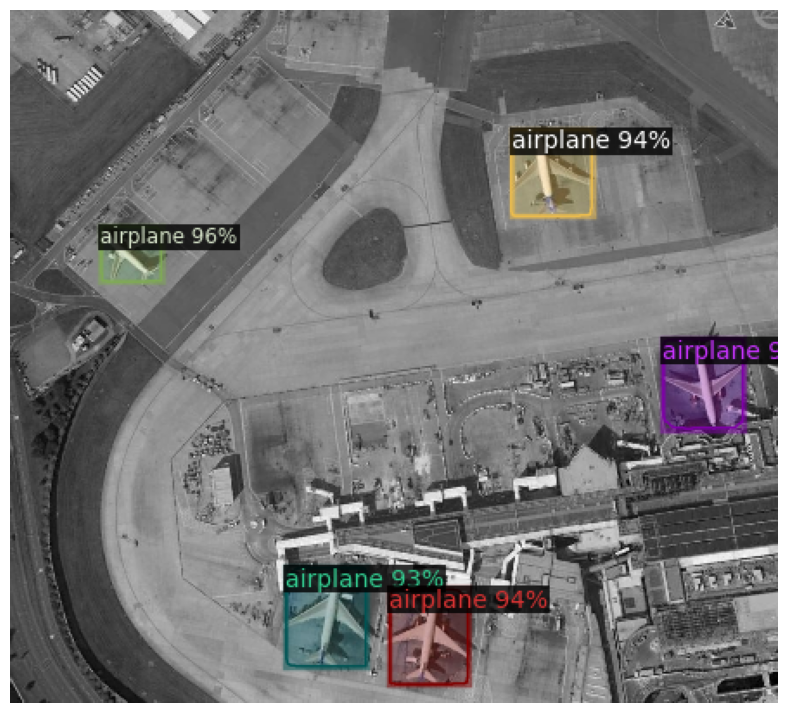

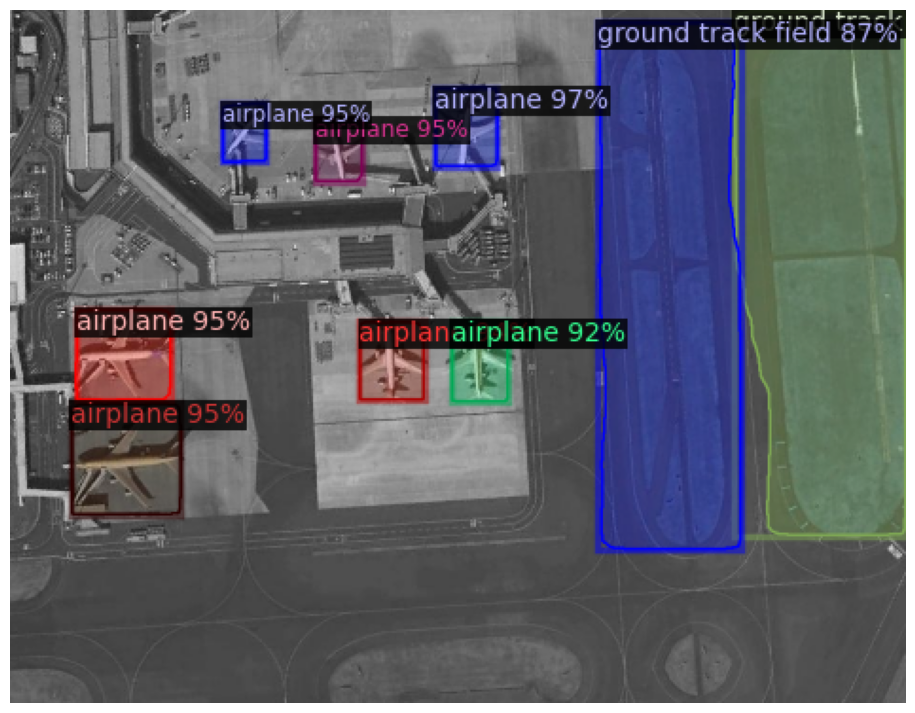

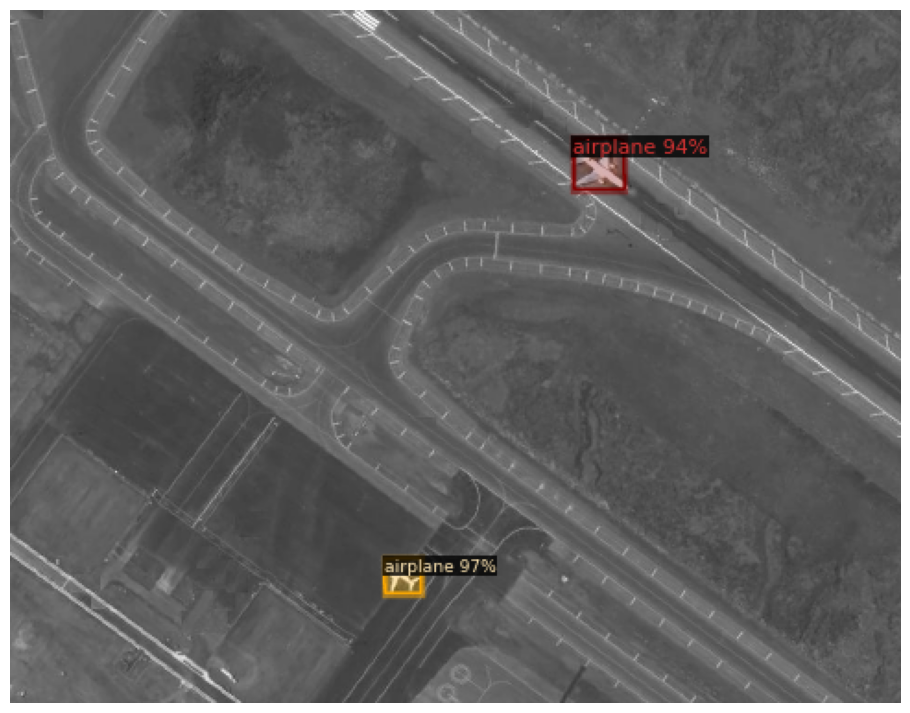

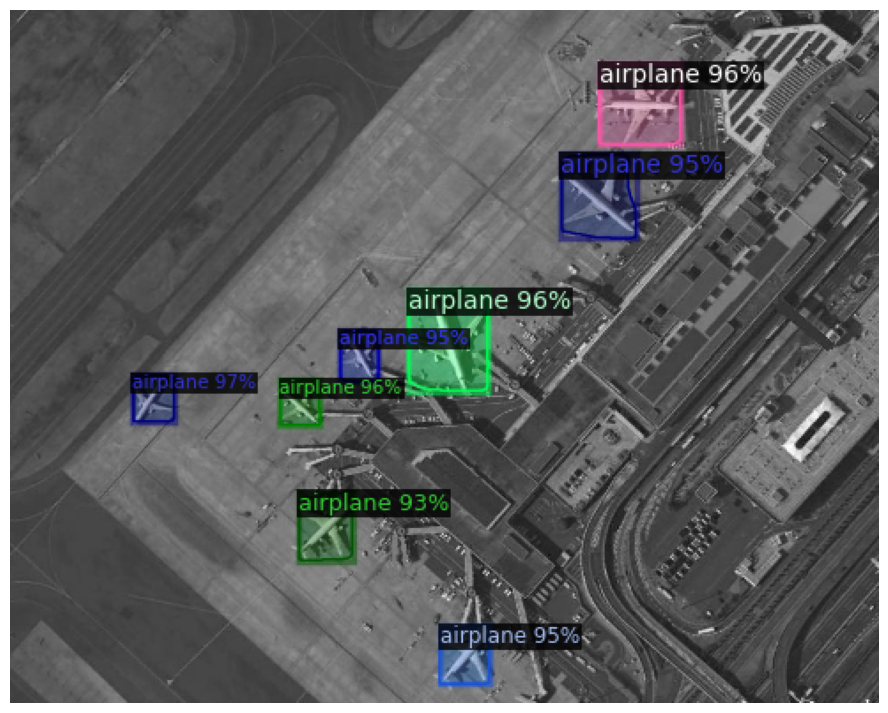

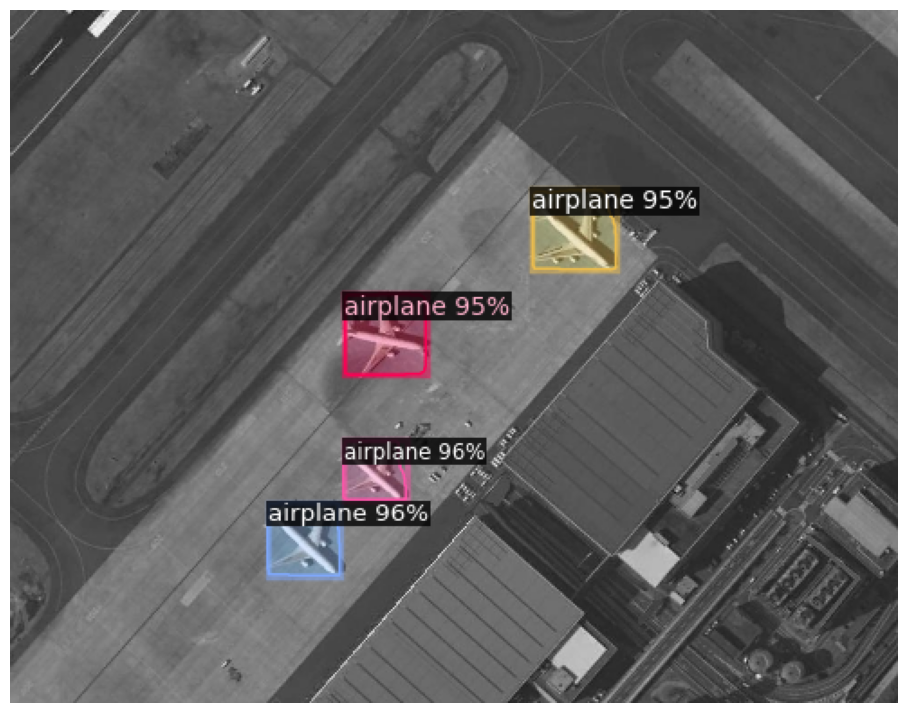

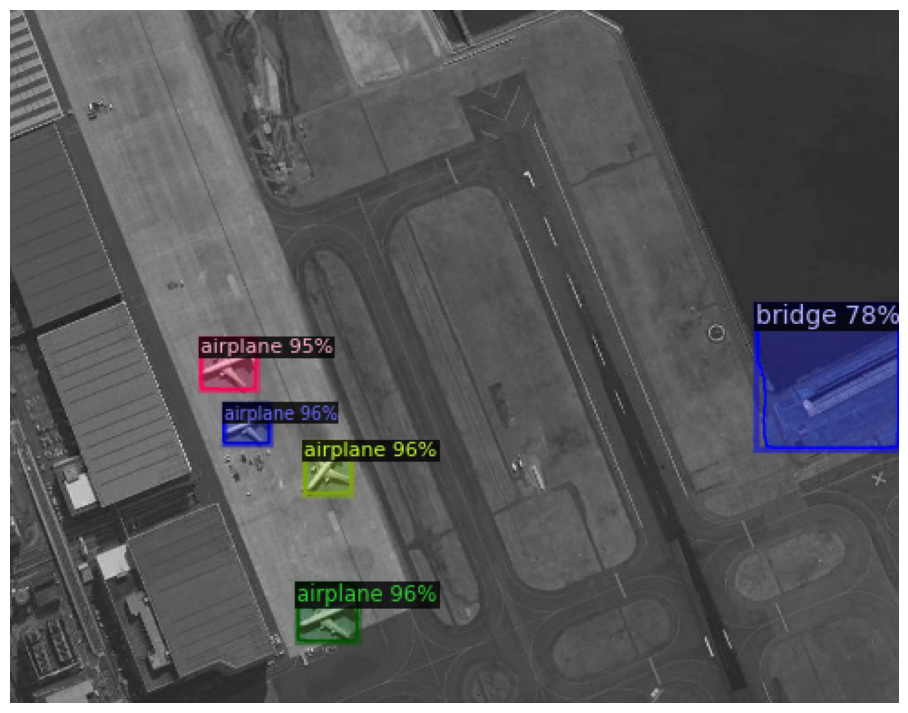

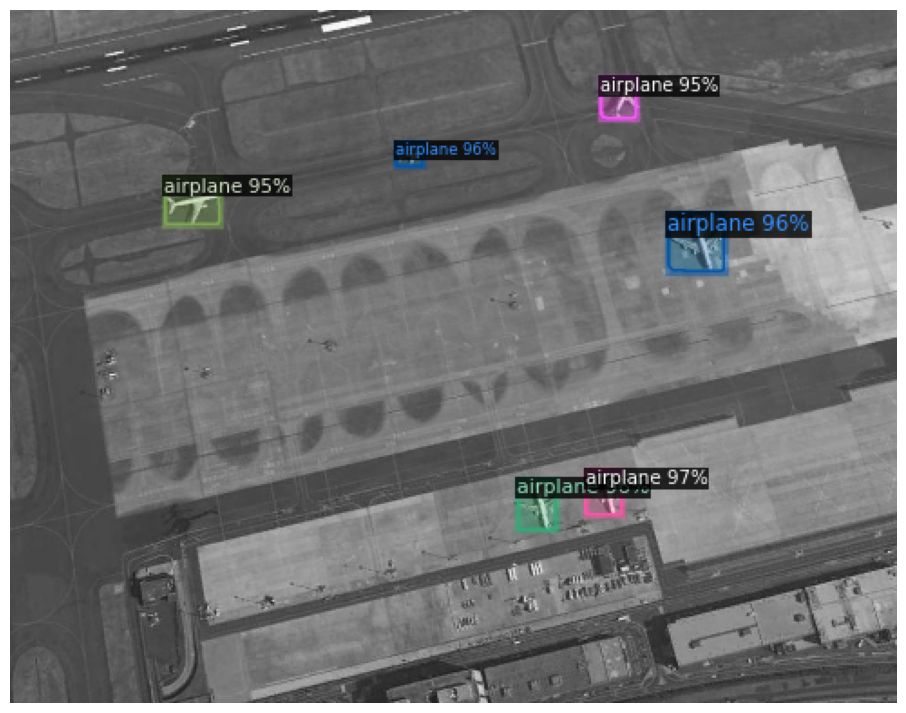

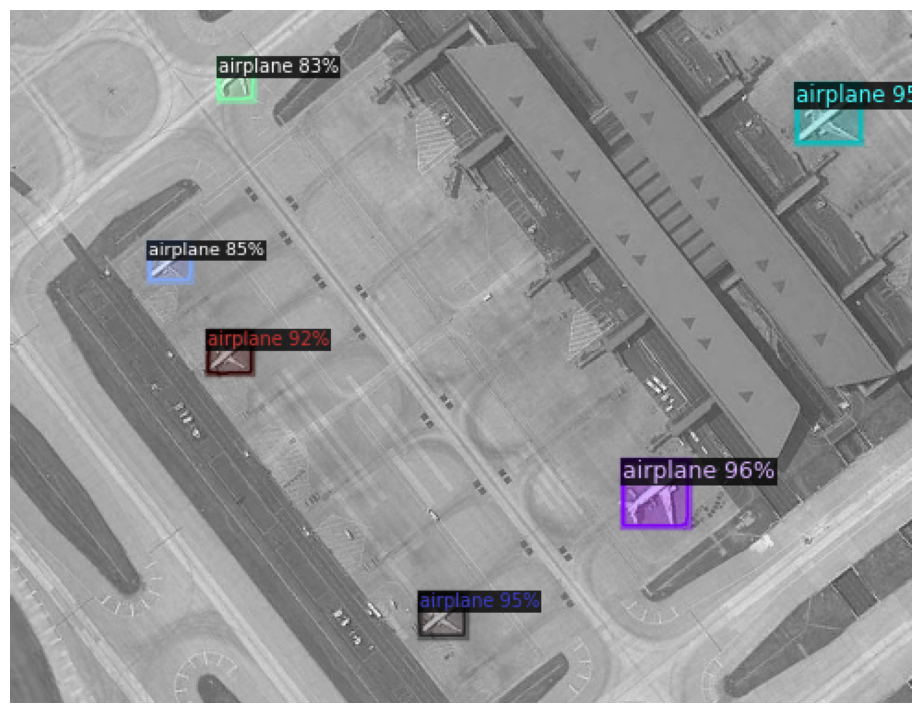

In [43]:
import os
import cv2

# Directory containing the images
image_dir = '/content/drive/MyDrive/datasets/NWPU_VHR-10/NWPU VHR-10 dataset/positive image set'

# Get the list of image file names
image_files = os.listdir(image_dir)

# Iterate over the image files
for filename in image_files[:10]:  # You may adjust the number as needed
    # Construct the full path to the image
    full_path = os.path.join(image_dir, filename)

    # Read the image
    im = cv2.imread(full_path)

    # Perform prediction
    outputs = predictor(im)

    # Visualize the predictions
    v = Visualizer(im[:, :, ::-1],  # Reverses the order of color channels for visualization
                   metadata=metadata_dicts,  # Metadata needed for visualization
                   scale=0.5,  # Scale factor for visualization
                   instance_mode=ColorMode.IMAGE_BW)  # Color mode for instance visualization
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))  # Draw instance predictions
    img = cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_RGBA2RGB)  # Convert image format for display
    plt.imshow(img)  # Display the image
    plt.axis('off')  # Turn off axis
    plt.show()  # Show the image
